# Study of Match Betting in Tennis

## 1. Introduction

The aim of this project is to construct a model for determining the probability of winning a tennis match via two different methods:
 - A Machine Learning approach using a Logistic Regression.
 - A traditional statistical approach using a Markov Chain.
 
Then, to visualise the accuracy of these models and to determine which is better, they will be tested against a bookmaker's odds to find out which would make the most money, if any.

## 2. Data

First, data was obtained for men's tennis matches between 2005 and 2020 from https://github.com/JeffSackmann.

To make a model for who will win a match, relevant features will be: when the match was played, what surface the match was played on, how many sets will be played, percentage of succesful first serves, percentage of points won on first & second serve (serve stats), and percentage of points won on opponents first & second serve (return stats).

For the sake of simplicity and facing no issues with players who only played a few matches, only players with more than 50 matches were chosen.

The player stats were then calculated for each of the above categories for each player in matches played **before** the match in question, with more recent matches given a higher emphasis than older matches.

The resulting DataFrame is below:

In [110]:
import numpy as np
import pandas as pd

data_df = pd.read_csv('Matches_With_Player_Stats2.csv')
data_df.head()

,tourney_date,surface,winner_name,loser_name,best_of,First_Serve_Percent_W,First_Serve_Win_W,Second_Serve_Win_W,First_Return_Win_W,Second_Return_Win_W,First_Serve_Percent_L,First_Serve_Win_L,Second_Serve_Win_L,First_Return_Win_L,Second_Return_Win_L
0,20061016,Hard,Robby Ginepri,Mario Ancic,3,0.640188,0.722467,0.549967,0.280016,0.558700,0.615870,0.765373,0.502347,0.303731,0.505488
1,20061016,Hard,Tommy Haas,Dominik Hrbaty,3,0.593931,0.757548,0.529212,0.282374,0.518541,0.581784,0.696311,0.518814,0.317541,0.464075
2,20061016,Hard,Roger Federer,Robby Ginepri,3,0.629646,0.760740,0.608670,0.339210,0.475166,0.640188,0.722467,0.549967,0.280016,0.558700
3,20060925,Hard,Ivan Ljubicic,Robby Ginepri,3,0.619658,0.783251,0.549492,0.288976,0.455461,0.636774,0.727773,0.548276,0.281037,0.563187
4,20060925,Hard,Ivan Ljubicic,Paradorn Srichaphan,3,0.619658,0.783251,0.549492,0.288976,0.455461,0.569171,0.739458,0.530797,0.276436,0.425772


The idea is then to obtain a number for each player for each match, which is the percentage of points won when serving, which will depend on all the above features (date, surface, sets, opponent, etc.). This number will then be used to model the probability of each player winning the match.

To calculate the percentage of points won for player A on their serve, $p_A$, and player B on their serve, $p_B$:

$p_A = s_A * p_{sA1} + (1- s_A)*p_{sA2} + r_{surface} - (s_A*p_{rB1} + (1-s_A)*p_{rB2})$

$p_B = s_B * p_{sB1} + (1- s_B)*p_{sB2} + r_{surface} - (s_B*p_{rA1} + (1-s_B)*p_{rA2})$

where $s_A$ and $s_B$ are the percentage of successful first serves for player A and B respectively,

$p_{sA1}$ , $p_{sA2}$, $p_{sB1}$ and $p_{sB2}$ are the percentage of points won on first and second serve for players A and B on the match surface,

$p_{rB1}$, $p_{rB2}$, $p_{rA1}$ and $p_{rA2}$ are the percentage of points won returning first and second serves for players B and A on the match surface,

and $r_{surface}$ is the mean percentage of points won returning serve for all players on the surface the match is played on.

To perform this for each player, we must first calculate the mean percentage of points won returning serve by surface and number of sets ($r_{surface}$).

In [111]:
first_serve_percent = (data_df['First_Serve_Percent_W'].mean() + data_df['First_Serve_Percent_L'].mean())/2

surfaces = ['Carpet','Clay','Grass','Hard']
best_of = [3,5]
means_table = []
for surface in surfaces: 
    for best in best_of:
        first_return = (data_df['First_Return_Win_W'][data_df['surface']==surface][data_df['best_of']==best].mean() + 
            data_df['First_Return_Win_L'][data_df['surface']==surface][data_df['best_of']==best].mean())/2
        second_return = (data_df['Second_Return_Win_W'][data_df['surface']==surface][data_df['best_of']==best].mean() + 
            data_df['Second_Return_Win_L'][data_df['surface']==surface][data_df['best_of']==best].mean())/2
        return_percent = first_serve_percent*first_return + (1-first_serve_percent)*second_return
        means_table.append(return_percent)
        
# Now, make a new column in the dataframe with this mean return percentage:
def get_mean_return(row):
    a = surfaces.index(row['surface'])
    b = best_of.index(row['best_of'])
    return means_table[2*a+b]

# apply this function to get new column.
data_df['Mean_Return'] = data_df.apply(get_mean_return, axis = 1)
data_df.head()

,tourney_date,surface,winner_name,loser_name,best_of,First_Serve_Percent_W,First_Serve_Win_W,Second_Serve_Win_W,First_Return_Win_W,Second_Return_Win_W,First_Serve_Percent_L,First_Serve_Win_L,Second_Serve_Win_L,First_Return_Win_L,Second_Return_Win_L,Mean_Return
0,20061016,Hard,Robby Ginepri,Mario Ancic,3,0.640188,0.722467,0.549967,0.280016,0.558700,0.615870,0.765373,0.502347,0.303731,0.505488,0.365238
1,20061016,Hard,Tommy Haas,Dominik Hrbaty,3,0.593931,0.757548,0.529212,0.282374,0.518541,0.581784,0.696311,0.518814,0.317541,0.464075,0.365238
2,20061016,Hard,Roger Federer,Robby Ginepri,3,0.629646,0.760740,0.608670,0.339210,0.475166,0.640188,0.722467,0.549967,0.280016,0.558700,0.365238
3,20060925,Hard,Ivan Ljubicic,Robby Ginepri,3,0.619658,0.783251,0.549492,0.288976,0.455461,0.636774,0.727773,0.548276,0.281037,0.563187,0.365238
4,20060925,Hard,Ivan Ljubicic,Paradorn Srichaphan,3,0.619658,0.783251,0.549492,0.288976,0.455461,0.569171,0.739458,0.530797,0.276436,0.425772,0.365238


Now, calculating $p_A$ and $p_B$ as above and introducing this into a new columm in our dataframe:

In [112]:
# percentage of points won on serve by winner
data_df['Winner_Win'] = (data_df['First_Serve_Percent_W']*data_df['First_Serve_Win_W'] + 
                    (1-data_df['First_Serve_Percent_W'])*data_df['Second_Serve_Win_W'] +
                    data_df['Mean_Return']-(data_df['First_Serve_Percent_W']*data_df['First_Return_Win_L'] + 
                    (1-data_df['First_Serve_Percent_W'])*data_df['Second_Return_Win_L']))

# percentage of points won on serve by loser
data_df['Loser_Win'] = (data_df['First_Serve_Percent_L']*data_df['First_Serve_Win_L'] + 
                    (1-data_df['First_Serve_Percent_L'])*data_df['Second_Serve_Win_L'] +
                    data_df['Mean_Return']-(data_df['First_Serve_Percent_L']*data_df['First_Return_Win_W'] + 
                    (1-data_df['First_Serve_Percent_L'])*data_df['Second_Return_Win_W']))

data_df.head()

,tourney_date,surface,winner_name,loser_name,best_of,First_Serve_Percent_W,First_Serve_Win_W,Second_Serve_Win_W,First_Return_Win_W,Second_Return_Win_W,First_Serve_Percent_L,First_Serve_Win_L,Second_Serve_Win_L,First_Return_Win_L,Second_Return_Win_L,Mean_Return,Winner_Win,Loser_Win
0,20061016,Hard,Robby Ginepri,Mario Ancic,3,0.640188,0.722467,0.549967,0.280016,0.558700,0.615870,0.765373,0.502347,0.303731,0.505488,0.365238,0.649312,0.642509
1,20061016,Hard,Tommy Haas,Dominik Hrbaty,3,0.593931,0.757548,0.529212,0.282374,0.518541,0.581784,0.696311,0.518814,0.317541,0.464075,0.365238,0.653022,0.606174
2,20061016,Hard,Roger Federer,Robby Ginepri,3,0.629646,0.760740,0.608670,0.339210,0.475166,0.640188,0.722467,0.549967,0.280016,0.558700,0.365238,0.686431,0.637509
3,20060925,Hard,Ivan Ljubicic,Robby Ginepri,3,0.619658,0.783251,0.549492,0.288976,0.455461,0.636774,0.727773,0.548276,0.281037,0.563187,0.365238,0.671230,0.678366
4,20060925,Hard,Ivan Ljubicic,Paradorn Srichaphan,3,0.619658,0.783251,0.549492,0.288976,0.455461,0.569171,0.739458,0.530797,0.276436,0.425772,0.365238,0.726346,0.654097


Given the structure of our data is that the winner is always in the same column, to remove any possible bias in the future model, a new column was introduced with either the winner or loser's win percentage at random.

In [113]:
from random import random
def f1(row):
    r = random()
    if r>=0.5:
        return row['Winner_Win']
    else:
        return row['Loser_Win']
    
data_df['RandWin'] = data_df.apply(f1,axis=1)

data_df.head()

,tourney_date,surface,winner_name,loser_name,best_of,First_Serve_Percent_W,First_Serve_Win_W,Second_Serve_Win_W,First_Return_Win_W,Second_Return_Win_W,First_Serve_Percent_L,First_Serve_Win_L,Second_Serve_Win_L,First_Return_Win_L,Second_Return_Win_L,Mean_Return,Winner_Win,Loser_Win,RandWin
0,20061016,Hard,Robby Ginepri,Mario Ancic,3,0.640188,0.722467,0.549967,0.280016,0.558700,0.615870,0.765373,0.502347,0.303731,0.505488,0.365238,0.649312,0.642509,0.649312
1,20061016,Hard,Tommy Haas,Dominik Hrbaty,3,0.593931,0.757548,0.529212,0.282374,0.518541,0.581784,0.696311,0.518814,0.317541,0.464075,0.365238,0.653022,0.606174,0.606174
2,20061016,Hard,Roger Federer,Robby Ginepri,3,0.629646,0.760740,0.608670,0.339210,0.475166,0.640188,0.722467,0.549967,0.280016,0.558700,0.365238,0.686431,0.637509,0.637509
3,20060925,Hard,Ivan Ljubicic,Robby Ginepri,3,0.619658,0.783251,0.549492,0.288976,0.455461,0.636774,0.727773,0.548276,0.281037,0.563187,0.365238,0.671230,0.678366,0.678366
4,20060925,Hard,Ivan Ljubicic,Paradorn Srichaphan,3,0.619658,0.783251,0.549492,0.288976,0.455461,0.569171,0.739458,0.530797,0.276436,0.425772,0.365238,0.726346,0.654097,0.726346


The corresponding column of the other player percentage of points won was then also calculated and a final column showing the winner of the match.

If the winner of the match was the player selected at random, this column's value will be 1, and if the random player was the loser it will have a value of 0.

In [114]:
def f2(row):
    if row['Winner_Win'] == row['RandWin']:
        return row['Loser_Win']
    else:
        return row['Winner_Win']

data_df['OtherWin'] = data_df.apply(f2,axis=1)
def f3(row):
    if row['Winner_Win'] == row['RandWin']:
        return 1
    else:
        return 0
data_df['Match_Winner'] = data_df.apply(f3, axis = 1)

data_df.head()

,tourney_date,surface,winner_name,loser_name,best_of,First_Serve_Percent_W,First_Serve_Win_W,Second_Serve_Win_W,First_Return_Win_W,Second_Return_Win_W,...,First_Serve_Win_L,Second_Serve_Win_L,First_Return_Win_L,Second_Return_Win_L,Mean_Return,Winner_Win,Loser_Win,RandWin,OtherWin,Match_Winner
0,20061016,Hard,Robby Ginepri,Mario Ancic,3,0.640188,0.722467,0.549967,0.280016,0.558700,...,0.765373,0.502347,0.303731,0.505488,0.365238,0.649312,0.642509,0.649312,0.642509,1
1,20061016,Hard,Tommy Haas,Dominik Hrbaty,3,0.593931,0.757548,0.529212,0.282374,0.518541,...,0.696311,0.518814,0.317541,0.464075,0.365238,0.653022,0.606174,0.606174,0.653022,0
2,20061016,Hard,Roger Federer,Robby Ginepri,3,0.629646,0.760740,0.608670,0.339210,0.475166,...,0.722467,0.549967,0.280016,0.558700,0.365238,0.686431,0.637509,0.637509,0.686431,0
3,20060925,Hard,Ivan Ljubicic,Robby Ginepri,3,0.619658,0.783251,0.549492,0.288976,0.455461,...,0.727773,0.548276,0.281037,0.563187,0.365238,0.671230,0.678366,0.678366,0.671230,0
4,20060925,Hard,Ivan Ljubicic,Paradorn Srichaphan,3,0.619658,0.783251,0.549492,0.288976,0.455461,...,0.739458,0.530797,0.276436,0.425772,0.365238,0.726346,0.654097,0.726346,0.654097,1


To visualize which of these features impacts the match winner the most, here is the correlation matrix:

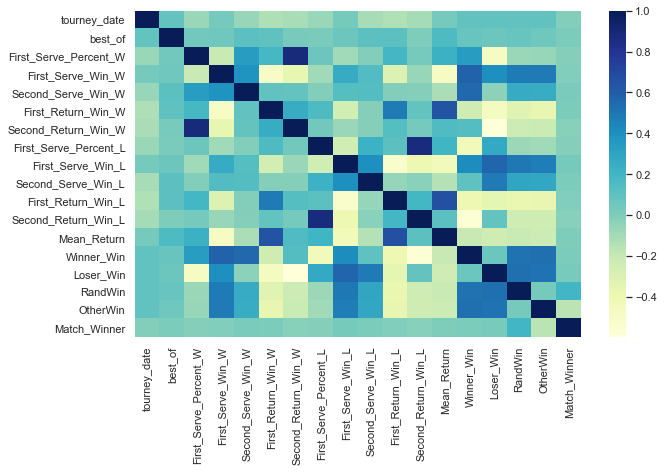

In [115]:
fig,ax = plt.subplots(figsize = (10,6))

sns.heatmap(data_df.corr(), cmap="YlGnBu",ax=ax)
plt.show()

From this we can observe that RandWin and OtherWin are the two main features that impact the match winner, so for simplicity, the model will be constructed with these two features only.

## 3. Methodology

### 3.1 Statistical approach using a Markov Chain

From our data we have two numbers, $p_A$ and $p_B$, which represent the percentage of points won on serve for players A and B, respectively.

To get the probability of winning a game from this number, consider the following grid:

A serve    |  0  |  15  |  30  |  40  |  Game
:---: | :---: | :---:  |  :---: |:---: | :---:
0  | | | | | 0
15  || | | | 0
30  || | | | 0
40  || | | | 
Game  | 1 |  1  |  1  |    | 


Each number in this grid will represent the chance that player A wins the game when serving when the score is (x,y), where x is player A's current score, and y is player B's current score.

I.e. row 2 column 1 will be the probability that on player A's serve, player A will win the game from 15-0.

The ones and zeroes represent the boundary conditions (player A wins the game if he/she wins the point at 40-0, 40-15 or 40-30; but loses if he loses the point at 0-40, 15-40, 30-40). The final boundary condition to find is what happens at deuce (40-40).

Player A will win the game if he/she wins 2 consecutive points, or wins one loses one, then wins two consecutive points, or wins two loses two, then wins two consecutive points, etc.

The probability of winning two consecutive points is: $p_A^2$

The probability of returning to deuce is: $p_A(1-p_A) + (1-p_A)p_A = 2p_A(1-p_A)$

So, probability of winning after four points is: $2p_A(1-p_A)p_A^2$

And after six points is: $(2p_A(1-p_A))^2p_A^2$

Generalising to 2n points:  $(2p_A(1-p_A))^{n-1}p_A^2$

Noticing that this is a geometric series and that $(2p_A(1-p_A))< 1$ since $p_A < 1$:

$ \sum \limits _{n=1} ^{\infty} (2p_A(1-p_A))^{n-1}p_A^2 = p_A^2 \sum \limits _{n=1} ^{\infty} (2p_A(1-p_A))^{n-1} = \frac{p_A^2}{1- 2p_A(1-p_A)} $


Going back to the above table, considering each element in the table as an element in a 5x5 matrix **M**, any element not in our boundary conditions will be found by the recurrence relation:

$ M_{ij} = p_A * M_{i+1, j} + (1-p_A)* M_{i, j+1}$ 


For example, for a player who wins 62% of points on serve, lets looks at the matrix by running the python code as follows:

In [121]:
serve_prob = 0.62

matrix = np.zeros(shape = (5,5))

for i in range(0,5):
    matrix[4][i] = 1 

for i in range(0,4):
    for j in range(0,4):
        if i + j == 0:
            matrix[3][3] = serve_prob**2/(serve_prob**2 + (1-serve_prob)**2)
        else:
            matrix[3-i][3-j] = matrix[3-i+1][3-j]*serve_prob + matrix[3-i][3-j+1]*(1-serve_prob)
            
print(matrix)

[[0.77586271 0.62253307 0.41109957 0.17324751 0.        ]
 [0.86983893 0.75212134 0.55687987 0.27943147 0.        ]
 [0.94198843 0.87178547 0.7269289  0.45069592 0.        ]
 [0.98501604 0.96056853 0.89623298 0.7269289  0.        ]
 [1.         1.         1.         1.         1.        ]]


To find the probability of winning a game from the start (0-0), we will need to find only the element $M_{00}$, which in above case was approximately 0.776.

This can be put into a function in python code as:

In [120]:
def game_prob(serve_prob):
    
    matrix = np.zeros(shape = (5,5))
    
    for i in range(0,5):
        matrix[4][i] = 1 
        
    for i in range(0,4):
        for j in range(0,4):
            if i + j == 0:
                matrix[3][3] = serve_prob**2/(serve_prob**2 + (1-serve_prob)**2)
            else:
                matrix[3-i][3-j] = matrix[3-i+1][3-j]*serve_prob + matrix[3-i][3-j+1]*(1-serve_prob)
    
    return matrix[0][0]

This logical process can then be repeated for tiebreak games, for sets, and then for matches.

The following code is the result of that process:

In [122]:
def tiebreak_prob(serve_a, serve_b):
    # need different formulae depending on who is serving, so will need to create two matrices, one for each player's serve
    # but where both represent the chance of player A winning.
    matrix_a = np.zeros(shape = (8,8))
    matrix_b = np.zeros(shape = (8,8))
    for i in range(0,8):
        #boundary conditions
        matrix_a[7][i] = 1 
        matrix_b[7][i] = 1
    for i in range(0,7):
        for j in range(0,7):
            if i + j == 0:
                #boundary conditions, obtained similarly to probability of winning a game from deuce
                matrix_a[6][6] = serve_a*(1-serve_b)/((1-serve_a)*serve_b + serve_a*(1-serve_b))
                matrix_b[6][6] = serve_a*(1-serve_b)/((1-serve_a)*serve_b + serve_a*(1-serve_b))
            elif (i + j) % 2 == 0:
                #when number of points is even, whoever is serving will only serve once more, so will have to use other players
                #matrix for the following point
                matrix_a[6-i][6-j] = matrix_b[6-i+1][6-j]*serve_a + matrix_b[6-i][6-j+1]*(1-serve_a)
                matrix_b[6-i][6-j] = matrix_a[6-i+1][6-j]*(1-serve_b) + matrix_a[6-i][6-j+1]*serve_b
            else:
                #when number of points is odd, the player serving plays two points on their serve so will use their own matrix
                #for the following point
                matrix_a[6-i][6-j] = matrix_a[6-i+1][6-j]*serve_a + matrix_a[6-i][6-j+1]*(1-serve_a)
                matrix_b[6-i][6-j] = matrix_b[6-i+1][6-j]*(1-serve_b) + matrix_b[6-i][6-j+1]*serve_b
    return matrix_a[0][0]

def set_prob(serve_a, serve_b):
    #similarly, will need two matrices, one for each player's serve, but each represent the chance of player A winning
    #and now our probability for each game is as calculated from above functions.
    game_serve_a = game_prob(serve_a)
    game_serve_b = game_prob(serve_b)
    matrix_a = np.zeros(shape = (8,8))
    matrix_b = np.zeros(shape = (8,8))
    
    for i in range(0,5):
        #boundary conditions
        matrix_a[6][i] = 1 
        matrix_b[6][i] = 1
    
    #what happens when the score is 6-6
    matrix_a[6][6] = tiebreak_prob(serve_a, serve_b)
    matrix_b[6][6] = tiebreak_prob(serve_a, serve_b)
    
    #can only get to 7-5 from 6-5, because rules of tennis, so these are additional boundary conditions.
    matrix_a[6][5] = game_serve_a + (1-game_serve_a)*matrix_b[6][6]
    matrix_a[5][6] = game_serve_a*matrix_b[6][6]
    matrix_b[6][5] = (1-game_serve_b) + game_serve_b*matrix_a[6][6]
    matrix_b[5][6] = (1-game_serve_b)*matrix_a[6][6]

    for i in range(0,6):
        for j in range(0,6):
            #notice the recurrence relation using other players matrix, as they take turns serving.
            matrix_a[5-i][5-j] = matrix_b[5-i+1][5-j]*game_serve_a + matrix_b[5-i][5-j+1]*(1-game_serve_a)
            matrix_b[5-i][5-j] = matrix_a[5-i+1][5-j]*(1-game_serve_b) + matrix_a[5-i][5-j+1]*game_serve_b
    
    return matrix_a[0][0]

def match_prob(serve_a, serve_b, sets):
    # very similar to above functions, but have to define how many sets they are playing to.
    matrix = np.zeros(shape = (sets+1, sets+1))
    
    for i in range(0,sets):
        matrix[sets][i] = 1
    
    set_a = set_prob(serve_a, serve_b)
    
    for i in range(0,sets):
        for j in range(0, sets):
            matrix[sets-1-i][sets-1-j] = matrix[sets-i][sets-1-j]*set_a + matrix[sets-1-i][sets-j]*(1-set_a)
            
    return matrix[0][0]

This final function match_prob is a Markov Chain model for who will win the match. It's limitations are that it assumes that the probability of each player winning a point on their serve remains constant during the match, which is not true, but is an approximation that can be made given the aim is to work out the probability of winning before the match is played.

### 3.2 Machine Learning approach using a Logistic Regression

From above figure in Data section, the conclusion was that the Match Winner could be modeled using two features, $p_A$ and $p_B$.

In [116]:
X = data_df[['RandWin','OtherWin']]

y =data_df['Match_Winner']

Now, make a pipeline for a logistic regression machine learning model using sklearn, and obtain the accuracy of said model:

In [118]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pipe = make_pipeline(StandardScaler(), LogisticRegression())

pipe.fit(X_train, y_train)

pipe.score(X_test, y_test)

0.6168947055324212

But, what does this actually mean? How good is this model? And the Markov Chain model?

The most practical way to measure how good the models are, is to put them up against bookmaker's odds, see how they perform and compare the two.

## 4. Analysis

Data for an online bookmakers odds was obtained for tennis matches between 2010 and 2017, and the player stats were obtained for each player in each of the matches, in the same way as described above, in the Data section.

In [119]:
bet_data = pd.read_csv('bet_data_with_new_stats2.csv').drop('Unnamed: 0',axis = 1)
bet_data.head()

,Date,Surface,Best of,Winner,Loser,B365W,B365L,new_date,First_Serve_Percent_W,First_Serve_Win_W,Second_Serve_Win_W,First_Return_Win_W,Second_Return_Win_W,First_Serve_Percent_L,First_Serve_Win_L,Second_Serve_Win_L,First_Return_Win_L,Second_Return_Win_L
0,40182,Hard,3,Gasquet R.,Nieminen J.,1.44,2.62,20100104,0.608885,0.734780,0.521143,0.299901,0.506911,0.631913,0.698509,0.513102,0.292623,0.536277
1,40182,Hard,3,Cilic M.,Kunitsyn I.,1.12,5.50,20100104,0.571887,0.739143,0.527008,0.303791,0.447791,0.590069,0.675906,0.506150,0.287608,0.483941
2,40182,Hard,3,Tipsarevic J.,Moya C.,1.40,2.75,20100104,0.567270,0.742927,0.512561,0.272898,0.477688,0.606653,0.734583,0.519705,0.277712,0.496151
3,40183,Hard,3,Baghdatis M.,Fish M.,1.36,3.00,20100105,0.569580,0.740056,0.525140,0.292721,0.436463,0.552385,0.753519,0.517379,0.283690,0.422216
4,40183,Hard,3,Blake J.,Querrey S.,1.72,2.00,20100105,0.584172,0.748231,0.529205,0.307250,0.477502,0.576088,0.750667,0.507197,0.283288,0.471642


Since only players with more than 50 matches played were selected, quite a few matches were removed from these stats, but there are a total of:

In [123]:
len(bet_data)

5108

5108 Matches between 2010 and 2017 where we have info on bookmaker prices.

This data needs to be in same format as was calculated above for our test data, so the models can be applied.

So, will get the mean percentage of points won returning serve:

In [125]:
def getMeanReturn2(row):
    a = surfaces.index(row['Surface'])
    b = best_of.index(row['Best of'])
    return means_table[2*a+b]  

bet_data['Mean_Return'] = bet_data.apply(getMeanReturn2, axis = 1)
bet_data.head()

,Date,Surface,Best of,Winner,Loser,B365W,B365L,new_date,First_Serve_Percent_W,First_Serve_Win_W,Second_Serve_Win_W,First_Return_Win_W,Second_Return_Win_W,First_Serve_Percent_L,First_Serve_Win_L,Second_Serve_Win_L,First_Return_Win_L,Second_Return_Win_L,Mean_Return
0,40182,Hard,3,Gasquet R.,Nieminen J.,1.44,2.62,20100104,0.608885,0.734780,0.521143,0.299901,0.506911,0.631913,0.698509,0.513102,0.292623,0.536277,0.365238
1,40182,Hard,3,Cilic M.,Kunitsyn I.,1.12,5.50,20100104,0.571887,0.739143,0.527008,0.303791,0.447791,0.590069,0.675906,0.506150,0.287608,0.483941,0.365238
2,40182,Hard,3,Tipsarevic J.,Moya C.,1.40,2.75,20100104,0.567270,0.742927,0.512561,0.272898,0.477688,0.606653,0.734583,0.519705,0.277712,0.496151,0.365238
3,40183,Hard,3,Baghdatis M.,Fish M.,1.36,3.00,20100105,0.569580,0.740056,0.525140,0.292721,0.436463,0.552385,0.753519,0.517379,0.283690,0.422216,0.365238
4,40183,Hard,3,Blake J.,Querrey S.,1.72,2.00,20100105,0.584172,0.748231,0.529205,0.307250,0.477502,0.576088,0.750667,0.507197,0.283288,0.471642,0.365238


And similarly, will need columns for $p_A$ and $p_B$ as described above.

In [126]:
bet_data['Winner_Win'] = (bet_data['First_Serve_Percent_W']*bet_data['First_Serve_Win_W'] + 
                    (1-bet_data['First_Serve_Percent_W'])*bet_data['Second_Serve_Win_W'] +
                    bet_data['Mean_Return']-(bet_data['First_Serve_Percent_W']*bet_data['First_Return_Win_L'] + 
                    (1-bet_data['First_Serve_Percent_W'])*bet_data['Second_Return_Win_L']))

bet_data['Loser_Win'] = (bet_data['First_Serve_Percent_L']*bet_data['First_Serve_Win_L'] + 
                    (1-bet_data['First_Serve_Percent_L'])*bet_data['Second_Serve_Win_L'] +
                    bet_data['Mean_Return']-(bet_data['First_Serve_Percent_L']*bet_data['First_Return_Win_W'] + 
                    (1-bet_data['First_Serve_Percent_L'])*bet_data['Second_Return_Win_W']))

bet_data.head()

,Date,Surface,Best of,Winner,Loser,B365W,B365L,new_date,First_Serve_Percent_W,First_Serve_Win_W,...,First_Return_Win_W,Second_Return_Win_W,First_Serve_Percent_L,First_Serve_Win_L,Second_Serve_Win_L,First_Return_Win_L,Second_Return_Win_L,Mean_Return,Winner_Win,Loser_Win
0,40182,Hard,3,Gasquet R.,Nieminen J.,1.44,2.62,20100104,0.608885,0.734780,...,0.299901,0.506911,0.631913,0.698509,0.513102,0.292623,0.536277,0.365238,0.628542,0.619403
1,40182,Hard,3,Cilic M.,Kunitsyn I.,1.12,5.50,20100104,0.571887,0.739143,...,0.303791,0.447791,0.590069,0.675906,0.506150,0.287608,0.483941,0.365238,0.641903,0.608735
2,40182,Hard,3,Tipsarevic J.,Moya C.,1.40,2.75,20100104,0.567270,0.742927,...,0.272898,0.477688,0.606653,0.734583,0.519705,0.277712,0.496151,0.365238,0.636241,0.661848
3,40183,Hard,3,Baghdatis M.,Fish M.,1.36,3.00,20100105,0.569580,0.740056,...,0.292721,0.436463,0.552385,0.753519,0.517379,0.283690,0.422216,0.365238,0.669476,0.655995
4,40183,Hard,3,Blake J.,Querrey S.,1.72,2.00,20100105,0.584172,0.748231,...,0.307250,0.477502,0.576088,0.750667,0.507197,0.283288,0.471642,0.365238,0.660781,0.633273


Performing same process of randomization to remove any bias towards winners:

In [127]:
from random import random
def f1(row):
    r = random()
    if r>=0.5:
        return row['Winner_Win']
    else:
        return row['Loser_Win']
    
bet_data['RandWin'] = bet_data.apply(f1,axis=1)

bet_data.head()

,Date,Surface,Best of,Winner,Loser,B365W,B365L,new_date,First_Serve_Percent_W,First_Serve_Win_W,...,Second_Return_Win_W,First_Serve_Percent_L,First_Serve_Win_L,Second_Serve_Win_L,First_Return_Win_L,Second_Return_Win_L,Mean_Return,Winner_Win,Loser_Win,RandWin
0,40182,Hard,3,Gasquet R.,Nieminen J.,1.44,2.62,20100104,0.608885,0.734780,...,0.506911,0.631913,0.698509,0.513102,0.292623,0.536277,0.365238,0.628542,0.619403,0.628542
1,40182,Hard,3,Cilic M.,Kunitsyn I.,1.12,5.50,20100104,0.571887,0.739143,...,0.447791,0.590069,0.675906,0.506150,0.287608,0.483941,0.365238,0.641903,0.608735,0.608735
2,40182,Hard,3,Tipsarevic J.,Moya C.,1.40,2.75,20100104,0.567270,0.742927,...,0.477688,0.606653,0.734583,0.519705,0.277712,0.496151,0.365238,0.636241,0.661848,0.636241
3,40183,Hard,3,Baghdatis M.,Fish M.,1.36,3.00,20100105,0.569580,0.740056,...,0.436463,0.552385,0.753519,0.517379,0.283690,0.422216,0.365238,0.669476,0.655995,0.655995
4,40183,Hard,3,Blake J.,Querrey S.,1.72,2.00,20100105,0.584172,0.748231,...,0.477502,0.576088,0.750667,0.507197,0.283288,0.471642,0.365238,0.660781,0.633273,0.660781


In [128]:
def f2(row):
    if row['Winner_Win'] == row['RandWin']:
        return row['Loser_Win']
    else:
        return row['Winner_Win']

bet_data['OtherWin'] = bet_data.apply(f2,axis=1)
def f3(row):
    if row['Winner_Win'] == row['RandWin']:
        return 1
    else:
        return 0
bet_data['Match_Winner'] = bet_data.apply(f3, axis = 1)

bet_data.head()

,Date,Surface,Best of,Winner,Loser,B365W,B365L,new_date,First_Serve_Percent_W,First_Serve_Win_W,...,First_Serve_Win_L,Second_Serve_Win_L,First_Return_Win_L,Second_Return_Win_L,Mean_Return,Winner_Win,Loser_Win,RandWin,OtherWin,Match_Winner
0,40182,Hard,3,Gasquet R.,Nieminen J.,1.44,2.62,20100104,0.608885,0.734780,...,0.698509,0.513102,0.292623,0.536277,0.365238,0.628542,0.619403,0.628542,0.619403,1
1,40182,Hard,3,Cilic M.,Kunitsyn I.,1.12,5.50,20100104,0.571887,0.739143,...,0.675906,0.506150,0.287608,0.483941,0.365238,0.641903,0.608735,0.608735,0.641903,0
2,40182,Hard,3,Tipsarevic J.,Moya C.,1.40,2.75,20100104,0.567270,0.742927,...,0.734583,0.519705,0.277712,0.496151,0.365238,0.636241,0.661848,0.636241,0.661848,1
3,40183,Hard,3,Baghdatis M.,Fish M.,1.36,3.00,20100105,0.569580,0.740056,...,0.753519,0.517379,0.283690,0.422216,0.365238,0.669476,0.655995,0.655995,0.669476,0
4,40183,Hard,3,Blake J.,Querrey S.,1.72,2.00,20100105,0.584172,0.748231,...,0.750667,0.507197,0.283288,0.471642,0.365238,0.660781,0.633273,0.660781,0.633273,1


### 4.1 Markov Chain Model


Now, finally a match probability can be obtained for each match using the Markov Chain model (match_prob):

In [129]:
def get_match_prob(row):
    if row['Best of'] == 3:
        sets = 2
    else:
        sets = 3
    return match_prob(row['RandWin'],row['OtherWin'],sets)

bet_data['Match_Prob'] =  bet_data.apply(get_match_prob,axis=1)
bet_data.head()

,Date,Surface,Best of,Winner,Loser,B365W,B365L,new_date,First_Serve_Percent_W,First_Serve_Win_W,...,Second_Serve_Win_L,First_Return_Win_L,Second_Return_Win_L,Mean_Return,Winner_Win,Loser_Win,RandWin,OtherWin,Match_Winner,Match_Prob
0,40182,Hard,3,Gasquet R.,Nieminen J.,1.44,2.62,20100104,0.608885,0.734780,...,0.513102,0.292623,0.536277,0.365238,0.628542,0.619403,0.628542,0.619403,1,0.546103
1,40182,Hard,3,Cilic M.,Kunitsyn I.,1.12,5.50,20100104,0.571887,0.739143,...,0.506150,0.287608,0.483941,0.365238,0.641903,0.608735,0.608735,0.641903,0,0.337357
2,40182,Hard,3,Tipsarevic J.,Moya C.,1.40,2.75,20100104,0.567270,0.742927,...,0.519705,0.277712,0.496151,0.365238,0.636241,0.661848,0.636241,0.661848,1,0.375802
3,40183,Hard,3,Baghdatis M.,Fish M.,1.36,3.00,20100105,0.569580,0.740056,...,0.517379,0.283690,0.422216,0.365238,0.669476,0.655995,0.655995,0.669476,0,0.434783
4,40183,Hard,3,Blake J.,Querrey S.,1.72,2.00,20100105,0.584172,0.748231,...,0.507197,0.283288,0.471642,0.365238,0.660781,0.633273,0.660781,0.633273,1,0.633348


Now, need to undo the randomization process in a new column to obtain the probability for the winner:

In [130]:
def f4(row):
    if row['Winner_Win'] == row['RandWin']:
        return row['Match_Prob']
    else:
        return 1 - row['Match_Prob']
    
bet_data['Winner_Prob'] = bet_data.apply(f4,axis = 1)
bet_data.head()

,Date,Surface,Best of,Winner,Loser,B365W,B365L,new_date,First_Serve_Percent_W,First_Serve_Win_W,...,First_Return_Win_L,Second_Return_Win_L,Mean_Return,Winner_Win,Loser_Win,RandWin,OtherWin,Match_Winner,Match_Prob,Winner_Prob
0,40182,Hard,3,Gasquet R.,Nieminen J.,1.44,2.62,20100104,0.608885,0.734780,...,0.292623,0.536277,0.365238,0.628542,0.619403,0.628542,0.619403,1,0.546103,0.546103
1,40182,Hard,3,Cilic M.,Kunitsyn I.,1.12,5.50,20100104,0.571887,0.739143,...,0.287608,0.483941,0.365238,0.641903,0.608735,0.608735,0.641903,0,0.337357,0.662643
2,40182,Hard,3,Tipsarevic J.,Moya C.,1.40,2.75,20100104,0.567270,0.742927,...,0.277712,0.496151,0.365238,0.636241,0.661848,0.636241,0.661848,1,0.375802,0.375802
3,40183,Hard,3,Baghdatis M.,Fish M.,1.36,3.00,20100105,0.569580,0.740056,...,0.283690,0.422216,0.365238,0.669476,0.655995,0.655995,0.669476,0,0.434783,0.565217
4,40183,Hard,3,Blake J.,Querrey S.,1.72,2.00,20100105,0.584172,0.748231,...,0.283288,0.471642,0.365238,0.660781,0.633273,0.660781,0.633273,1,0.633348,0.633348


How good is this model? By obtaining the confusion matrix, the number of false positives and negatives can be visualised:

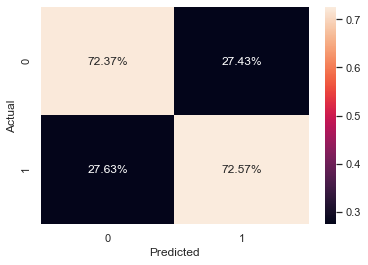

In [198]:
confusion_matrix = pd.crosstab(bet_data['Match_Winner'], bet_data['Match_Prob'].map(lambda x: 1 if x>=0.5 else 0), rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt='.2%')
plt.show()

But, to display this information in a more impactful way, the model will be tested against bookmaker prices to try and make a profit.

First, bookmakers effective probability for both winner and loser was found (note they will add up to above 100% because of bookmakers overround):

In [131]:
bet_data['Bookie_Winner_Prob'] = 1/bet_data['B365W']
bet_data['Bookie_Loser_Prob'] = 1/bet_data['B365L']
bet_data.head()

,Date,Surface,Best of,Winner,Loser,B365W,B365L,new_date,First_Serve_Percent_W,First_Serve_Win_W,...,Mean_Return,Winner_Win,Loser_Win,RandWin,OtherWin,Match_Winner,Match_Prob,Winner_Prob,Bookie_Winner_Prob,Bookie_Loser_Prob
0,40182,Hard,3,Gasquet R.,Nieminen J.,1.44,2.62,20100104,0.608885,0.734780,...,0.365238,0.628542,0.619403,0.628542,0.619403,1,0.546103,0.546103,0.694444,0.381679
1,40182,Hard,3,Cilic M.,Kunitsyn I.,1.12,5.50,20100104,0.571887,0.739143,...,0.365238,0.641903,0.608735,0.608735,0.641903,0,0.337357,0.662643,0.892857,0.181818
2,40182,Hard,3,Tipsarevic J.,Moya C.,1.40,2.75,20100104,0.567270,0.742927,...,0.365238,0.636241,0.661848,0.636241,0.661848,1,0.375802,0.375802,0.714286,0.363636
3,40183,Hard,3,Baghdatis M.,Fish M.,1.36,3.00,20100105,0.569580,0.740056,...,0.365238,0.669476,0.655995,0.655995,0.669476,0,0.434783,0.565217,0.735294,0.333333
4,40183,Hard,3,Blake J.,Querrey S.,1.72,2.00,20100105,0.584172,0.748231,...,0.365238,0.660781,0.633273,0.660781,0.633273,1,0.633348,0.633348,0.581395,0.500000


Now, to test the model, the approach in this project will be to place a bet whenever there is a big difference in the models prediction compared to the bookmakers prediction. In this case, the margin chosen was 15%. 

A bet size of 10 was chosen to show results.

In [132]:
margin = 0.15
bet_size = 10

def getProfitLoss(row):
    win_diff = row['Winner_Prob']-row['Bookie_Winner_Prob']
    
    los_diff = (1-row['Winner_Prob'])-row['Bookie_Loser_Prob']

    if win_diff > margin:
        profitloss = row['B365W']*bet_size-bet_size
    elif los_diff > margin:
        profitloss = -bet_size
    else:
        profitloss = 0
    return profitloss

bet_data['ProfitLoss'] = bet_data.apply(getProfitLoss,axis = 1)
bet_data.head(10)

,Date,Surface,Best of,Winner,Loser,B365W,B365L,new_date,First_Serve_Percent_W,First_Serve_Win_W,...,Winner_Win,Loser_Win,RandWin,OtherWin,Match_Winner,Match_Prob,Winner_Prob,Bookie_Winner_Prob,Bookie_Loser_Prob,ProfitLoss
0,40182,Hard,3,Gasquet R.,Nieminen J.,1.44,2.62,20100104,0.608885,0.734780,...,0.628542,0.619403,0.628542,0.619403,1,0.546103,0.546103,0.694444,0.381679,0.0
1,40182,Hard,3,Cilic M.,Kunitsyn I.,1.12,5.50,20100104,0.571887,0.739143,...,0.641903,0.608735,0.608735,0.641903,0,0.337357,0.662643,0.892857,0.181818,-10.0
2,40182,Hard,3,Tipsarevic J.,Moya C.,1.40,2.75,20100104,0.567270,0.742927,...,0.636241,0.661848,0.636241,0.661848,1,0.375802,0.375802,0.714286,0.363636,-10.0
3,40183,Hard,3,Baghdatis M.,Fish M.,1.36,3.00,20100105,0.569580,0.740056,...,0.669476,0.655995,0.655995,0.669476,0,0.434783,0.565217,0.735294,0.333333,0.0
4,40183,Hard,3,Blake J.,Querrey S.,1.72,2.00,20100105,0.584172,0.748231,...,0.660781,0.633273,0.660781,0.633273,1,0.633348,0.633348,0.581395,0.500000,0.0
5,40183,Hard,3,Monfils G.,Dent T.,1.22,4.00,20100105,0.591775,0.740783,...,0.656112,0.649176,0.656112,0.649176,1,0.534036,0.534036,0.819672,0.250000,-10.0
6,40183,Hard,3,Ginepri R.,Soderling R.,7.00,1.08,20100105,0.616108,0.726328,...,0.645320,0.648187,0.645320,0.648187,1,0.485828,0.485828,0.142857,0.925926,60.0
7,40183,Hard,3,Nadal R.,Bolelli S.,1.02,12.00,20100105,0.646588,0.720767,...,0.711633,0.620545,0.620545,0.711633,0,0.134932,0.865068,0.980392,0.083333,0.0
8,40183,Hard,3,Federer R.,Rochus C.,1.00,21.00,20100105,0.620027,0.760955,...,0.679201,0.571304,0.571304,0.679201,0,0.086715,0.913285,1.000000,0.047619,0.0
9,40184,Hard,3,Blake J.,Gicquel M.,1.36,3.00,20100106,0.584172,0.748231,...,0.686056,0.613604,0.686056,0.613604,1,0.814282,0.814282,0.735294,0.333333,0.0


Total profit or loss is therefore:

In [133]:
bet_data['ProfitLoss'].sum()

8111.5

A great result! How many bets were placed?

In [134]:
len(bet_data['ProfitLoss'][bet_data['ProfitLoss']!=0])

1793

So, bets would have been placed on 1793 out of 5108 matches, about 1 in 3.

With a profit of 8111 having staked 1793 * 10. That's a 45% return on investment (ROI). Not bad.

### 4.2 Machine Learning Logistic Regression Model

Now, the same process and logic will be applied to the ML LR model.

In [135]:
X2 = bet_data[['RandWin','OtherWin']]

In [137]:
bet_data['ML_Prob'] = pipe.predict_proba(X2)[:,1]
bet_data.head()

,Date,Surface,Best of,Winner,Loser,B365W,B365L,new_date,First_Serve_Percent_W,First_Serve_Win_W,...,Loser_Win,RandWin,OtherWin,Match_Winner,Match_Prob,Winner_Prob,Bookie_Winner_Prob,Bookie_Loser_Prob,ProfitLoss,ML_Prob
0,40182,Hard,3,Gasquet R.,Nieminen J.,1.44,2.62,20100104,0.608885,0.734780,...,0.619403,0.628542,0.619403,1,0.546103,0.546103,0.694444,0.381679,0.0,0.517314
1,40182,Hard,3,Cilic M.,Kunitsyn I.,1.12,5.50,20100104,0.571887,0.739143,...,0.608735,0.608735,0.641903,0,0.337357,0.662643,0.892857,0.181818,-10.0,0.421004
2,40182,Hard,3,Tipsarevic J.,Moya C.,1.40,2.75,20100104,0.567270,0.742927,...,0.661848,0.636241,0.661848,1,0.375802,0.375802,0.714286,0.363636,-10.0,0.442532
3,40183,Hard,3,Baghdatis M.,Fish M.,1.36,3.00,20100105,0.569580,0.740056,...,0.655995,0.655995,0.669476,0,0.434783,0.565217,0.735294,0.333333,0.0,0.472807
4,40183,Hard,3,Blake J.,Querrey S.,1.72,2.00,20100105,0.584172,0.748231,...,0.633273,0.660781,0.633273,1,0.633348,0.633348,0.581395,0.500000,0.0,0.563625


As above, the confusion matrix will give and idea of how accurate this model is:

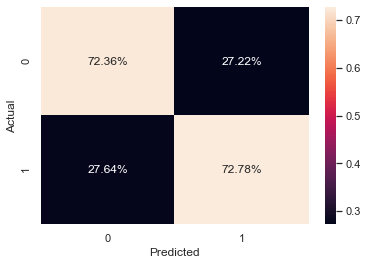

In [199]:
confusion_matrix = pd.crosstab(bet_data['Match_Winner'], bet_data['ML_Prob'].map(lambda x: 1 if x>=0.5 else 0), rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt='.2%')
plt.show()

Now, applying same logic as above but for the Logistic Regression Model.

In [138]:
def f5(row):
    if row['Winner_Win'] == row['RandWin']:
        return row['ML_Prob']
    else:
        return 1 - row['ML_Prob']
    
bet_data['ML_Winner_Prob'] = bet_data.apply(f5,axis = 1)
bet_data.head()

,Date,Surface,Best of,Winner,Loser,B365W,B365L,new_date,First_Serve_Percent_W,First_Serve_Win_W,...,RandWin,OtherWin,Match_Winner,Match_Prob,Winner_Prob,Bookie_Winner_Prob,Bookie_Loser_Prob,ProfitLoss,ML_Prob,ML_Winner_Prob
0,40182,Hard,3,Gasquet R.,Nieminen J.,1.44,2.62,20100104,0.608885,0.734780,...,0.628542,0.619403,1,0.546103,0.546103,0.694444,0.381679,0.0,0.517314,0.517314
1,40182,Hard,3,Cilic M.,Kunitsyn I.,1.12,5.50,20100104,0.571887,0.739143,...,0.608735,0.641903,0,0.337357,0.662643,0.892857,0.181818,-10.0,0.421004,0.578996
2,40182,Hard,3,Tipsarevic J.,Moya C.,1.40,2.75,20100104,0.567270,0.742927,...,0.636241,0.661848,1,0.375802,0.375802,0.714286,0.363636,-10.0,0.442532,0.442532
3,40183,Hard,3,Baghdatis M.,Fish M.,1.36,3.00,20100105,0.569580,0.740056,...,0.655995,0.669476,0,0.434783,0.565217,0.735294,0.333333,0.0,0.472807,0.527193
4,40183,Hard,3,Blake J.,Querrey S.,1.72,2.00,20100105,0.584172,0.748231,...,0.660781,0.633273,1,0.633348,0.633348,0.581395,0.500000,0.0,0.563625,0.563625


Again, with a margin of 15% and a bet size of 10.

In [139]:
margin = 0.15
bet_size = 10

def getMLProfitLoss(row):
    win_diff = row['ML_Winner_Prob']-row['Bookie_Winner_Prob']
    los_diff = (1-row['ML_Winner_Prob'])-row['Bookie_Loser_Prob']

    if win_diff > margin:
        profitloss = row['B365W']*bet_size - bet_size
    elif los_diff > margin:
        profitloss = -bet_size
    else:
        profitloss = 0
    return profitloss

bet_data['MLProfitLoss'] = bet_data.apply(getMLProfitLoss,axis = 1)
bet_data.head(10)

,Date,Surface,Best of,Winner,Loser,B365W,B365L,new_date,First_Serve_Percent_W,First_Serve_Win_W,...,OtherWin,Match_Winner,Match_Prob,Winner_Prob,Bookie_Winner_Prob,Bookie_Loser_Prob,ProfitLoss,ML_Prob,ML_Winner_Prob,MLProfitLoss
0,40182,Hard,3,Gasquet R.,Nieminen J.,1.44,2.62,20100104,0.608885,0.734780,...,0.619403,1,0.546103,0.546103,0.694444,0.381679,0.0,0.517314,0.517314,0.0
1,40182,Hard,3,Cilic M.,Kunitsyn I.,1.12,5.50,20100104,0.571887,0.739143,...,0.641903,0,0.337357,0.662643,0.892857,0.181818,-10.0,0.421004,0.578996,-10.0
2,40182,Hard,3,Tipsarevic J.,Moya C.,1.40,2.75,20100104,0.567270,0.742927,...,0.661848,1,0.375802,0.375802,0.714286,0.363636,-10.0,0.442532,0.442532,-10.0
3,40183,Hard,3,Baghdatis M.,Fish M.,1.36,3.00,20100105,0.569580,0.740056,...,0.669476,0,0.434783,0.565217,0.735294,0.333333,0.0,0.472807,0.527193,0.0
4,40183,Hard,3,Blake J.,Querrey S.,1.72,2.00,20100105,0.584172,0.748231,...,0.633273,1,0.633348,0.633348,0.581395,0.500000,0.0,0.563625,0.563625,0.0
5,40183,Hard,3,Monfils G.,Dent T.,1.22,4.00,20100105,0.591775,0.740783,...,0.649176,1,0.534036,0.534036,0.819672,0.250000,-10.0,0.517760,0.517760,-10.0
6,40183,Hard,3,Ginepri R.,Soderling R.,7.00,1.08,20100105,0.616108,0.726328,...,0.648187,1,0.485828,0.485828,0.142857,0.925926,60.0,0.494104,0.494104,60.0
7,40183,Hard,3,Nadal R.,Bolelli S.,1.02,12.00,20100105,0.646588,0.720767,...,0.711633,0,0.134932,0.865068,0.980392,0.083333,0.0,0.305802,0.694198,-10.0
8,40183,Hard,3,Federer R.,Rochus C.,1.00,21.00,20100105,0.620027,0.760955,...,0.679201,0,0.086715,0.913285,1.000000,0.047619,0.0,0.267813,0.732187,-10.0
9,40184,Hard,3,Blake J.,Gicquel M.,1.36,3.00,20100106,0.584172,0.748231,...,0.613604,1,0.814282,0.814282,0.735294,0.333333,0.0,0.661785,0.661785,0.0


The big moment, which one makes more money?

In [140]:
bet_data['MLProfitLoss'].sum()

2241.2999999999997

And how many bets here?

In [141]:
len(bet_data['MLProfitLoss'][bet_data['MLProfitLoss']!=0])

2070

2241 profit having staked 20700 is an ROI of approximately 10.8%. Much lower than the Markov Chain model, but still a nice profit!

## 5. Results and Discussion

Results from the previous sections will now be shown in a more visual way.

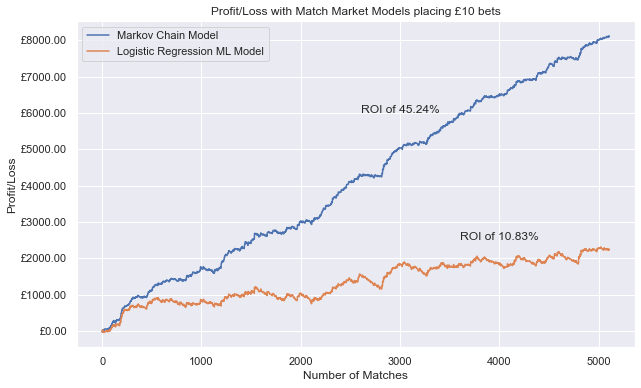

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

roi_mcm = bet_data['ProfitLoss'].sum()/(len(bet_data['ProfitLoss'][bet_data['ProfitLoss']!=0])*10)
roi_lr = bet_data['MLProfitLoss'].sum()/(len(bet_data['MLProfitLoss'][bet_data['MLProfitLoss']!=0])*10)

sns.set()
fig, ax = plt.subplots(figsize=(10,6))

bet_data['ProfitLoss'].cumsum().plot(label = 'Markov Chain Model', ax=ax)
bet_data['MLProfitLoss'].cumsum().plot(label = 'Logistic Regression ML Model', ax=ax)
ax.set_title('Profit/Loss with Match Market Models placing £10 bets')
ax.set_xlabel('Number of Matches')
ax.set_ylabel('Profit/Loss')
ax.yaxis.set_major_formatter('£{x:1.2f}')
ax.legend()
plt.text(3000,6000,'ROI of {:0.2f}%'.format(roi_mcm*100),horizontalalignment='center')
plt.text(4000,2500,'ROI of {:0.2f}%'.format(roi_lr*100),horizontalalignment='center')
plt.show()

From this graph, it can be observed that if one were to zoom in on a particular month or even group of months, one would find periods of no profit or even long periods of losing money, but the overall upward trend is undeniable for both models.

If one wanted to use this for personal gain, therefore, this factor of natural variation and possible months of losing money would have to be taken into account, by only staking a very small amount of one's total capital per match.

Additionally, one could vastly improve results by not always staking the same amount of money (10 in above results), but by placing larger bets for higher confidence bets and larger differences in model prediction vs bookmaker odds.

In any case, the results are outstanding, but how much could one make per year?

In [190]:
from datetime import datetime

dates = bet_data['new_date'].map(lambda x: datetime.strptime(str(x),'%Y%m%d').date())

total_days = dates.max() - dates.min()

total_years = total_days.days/365.25

bet_data['ProfitLoss'].sum()/total_years

1050.611835106383

Therefore, one could make an average of 105x per year where x is the size of the bets made. 
* A bet size of £1000 would yield a profit of £105,000 a year. Bear in mind, this is only by betting on the Match winner, and only on players with more than 50 matches in the data. One could multiply by 3 or 4 this figure by including other markets, players, etc etc.

But, how is this possible? Why is there such a big profit to be made?

One possible reason is that the distribution of prices given by the bookmaker studied in this project is a far from what it should be. 

Looking at the distribution of probabilities for bookmakers prices against the two models described above:

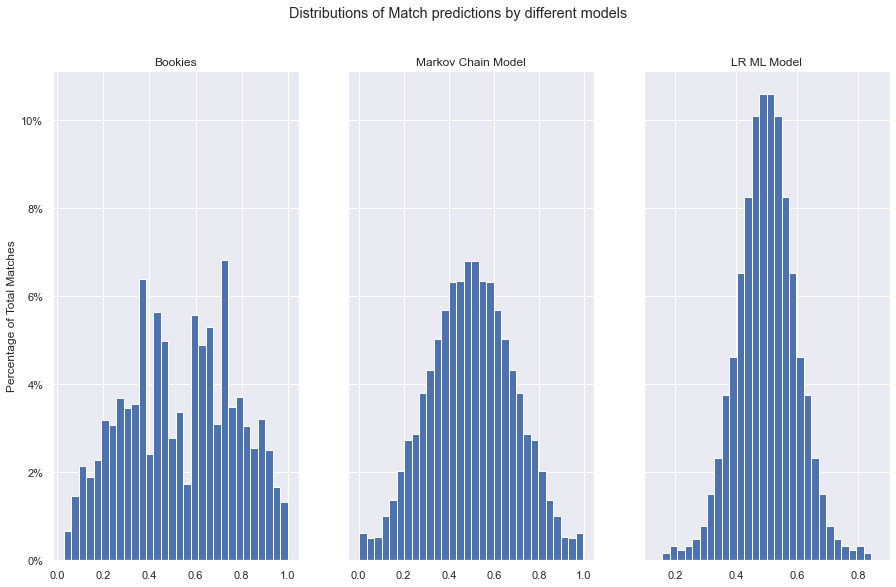

In [205]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (15,9),sharey = True)

fig.suptitle('Distributions of Match predictions by different models')
ax1.hist(bet_data['Bookie_Winner_Prob'].append(bet_data['Bookie_Loser_Prob']),bins=30, weights=np.ones(len(bet_data)*2) / (2*len(bet_data)))
ax1.set_title('Bookies')
ax2.hist(bet_data['Winner_Prob'].append(bet_data['Winner_Prob'].map(lambda x: 1-x)),bins = 30, weights=np.ones(len(bet_data)*2) / (2*len(bet_data)))
ax2.set_title('Markov Chain Model')
ax3.hist(bet_data['ML_Winner_Prob'].append(bet_data['ML_Winner_Prob'].map(lambda x: 1-x)),bins = 30, weights=np.ones(len(bet_data)*2) / (2*len(bet_data)))
ax3.set_title('LR ML Model')
ax1.yaxis.set_major_formatter('{:.0%}'.format)
ax1.set_ylabel('Percentage of Total Matches')
plt.show()

This shows that the variance of prices from bookmakers is a lot higher than either of the models constructed in this project.

This means that this particular bookmaker tends to, on average, predict much fewer evenly matched matches and many more one sided matches than there actually are.

In contrast, the Logistic Regression model appears to have too little variance, which could be one of the reasons it doesnt perform as well as the Markov Chain model.

This does not mean that these models are necessarily that much better than the bookmaker's odds, simply that the bookmakers are exploitable on certain matches where the models constructed in this project are closer to the right answer.


## 6. Conclusion


In this project, two different models were made, one with a traditional statistical approach, one with a Machine Learning (ML) approach. 

The two were then tested against a bookmaker's odds to find which would perform better (make more money) with the same parameters. The result was that the Markov Chain model performed significantly better than the Logistic Regression (LR) ML model, making a 45% return on investment compared to a 10.8% for the LR ML model.

This result means that the bookmaker's odds were exploitable for this market for a large proportion of the matches (roughly 1 in 3), and that the models constructed here are significantly better than the bookmakers for this period. However, since 2017, a lot of work has been done by bookmakers to improve prices, so it may no longer be the case. This remains to be tested, but given the very simple nature of the models in this project, it is very much within reason that more adjustments to these models can be made in order to out perform bookmakers prices.

## 7. Acknowledgements

Credit to Jeff Sackmann for his excellent effort making and maintaining tennis data (https://github.com/JeffSackmann).